En esta notebook analizamos el efecto del return conditioning en el Decision Transformer.
La idea es evaluar qué pasa cuando condicionamos al modelo con distintos valores objetivo de return-to-go (R̂), y también cómo se comporta en usuarios nuevos (cold-start) separados por grupo.

In [ ]:
import numpy as np
import json, pickle
import torch 
import matplotlib.pyplot as plt
# ===== Config general =====
NUM_ITEMS = 752
NUM_GROUPS = 8
CONTEXT_LEN = 20

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# cargar train trajectories (para percentiles)
with open("../data/processed/trajectories_train.pkl", "rb") as f:
    train_trajectories = pickle.load(f)

# cargar test users
with open("../data/test_users/netflix8_test.json", "r") as f:
    test_users = json.load(f)

print("Train trajectories:", len(train_trajectories))
print("Test users:", len(test_users))


Device: cpu
Train trajectories: 16000
Test users: 1600


Cargamos las trayectorias de training generadas en la Parte 1.
Las vamos a usar para calcular estadísticos de returns (percentiles).

In [12]:
with open("../data/processed/trajectories_train.pkl", "rb") as f:
    train_trajectories = pickle.load(f)

print("Train trajectories:", len(train_trajectories))
print("Keys ejemplo:", train_trajectories[0].keys())


Train trajectories: 16000
Keys ejemplo: dict_keys(['items', 'ratings', 'returns_to_go', 'timesteps', 'user_group'])


Cargamos los usuarios de test (cold-start).
Estos usuarios no aparecieron en training y se usan para evaluar generalización.

In [13]:
test_path = "../data/test_users/netflix8_test.json"
with open(test_path, "r") as f:
    test_users = json.load(f)

print("Test users:", len(test_users))
print("Keys ejemplo test user:", test_users[0].keys())


Test users: 1600
Keys ejemplo test user: dict_keys(['group', 'iter', 'items', 'ratings'])


Definimos la misma arquitectura entrenada en la Parte 2 y cargamos el checkpoint guardado.
Esto nos permite evaluar sin re-entrenar.

In [ ]:
import torch.nn as nn
class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.rtg_embedding = nn.Linear(1, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers, enable_nested_tensor=False
        )

        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )
        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, actions, returns_to_go, timesteps, user_groups, attention_mask=None):
        B, L = states.shape

        state_emb = self.item_embedding(states)
        rtg_emb   = self.rtg_embedding(returns_to_go)
        time_emb  = self.timestep_embedding(timesteps)

        group_emb = self.group_embedding(user_groups).unsqueeze(1).expand(-1, L, -1)

        h = self.ln(state_emb + rtg_emb + time_emb + group_emb)

        causal_mask = nn.Transformer.generate_square_subsequent_mask(L).to(h.device)

        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None

        h = self.transformer(h, mask=causal_mask, src_key_padding_mask=src_key_padding_mask)
        logits = self.predict_item(h)
        return logits


model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    context_length=CONTEXT_LEN
).to(DEVICE)

ckpt_path = "../results/checkpoints/dt_netflix.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

print("✅ modelo cargado desde checkpoint")


✅ modelo cargado desde checkpoint


Usamos métricas estándar de recomendación para medir ranking.

* HR@K: si el item real aparece en el top-K

* NDCG@K: además de aparecer, premia si está más arriba

* MRR: inverso de la posición exacta del item real

In [17]:
def hit_rate_at_k(scores, target, k=10):
    top_k = torch.topk(scores, k).indices
    return float((top_k == target).any())

def ndcg_at_k(scores, target, k=10):
    top_k = torch.topk(scores, k).indices
    rel = (top_k == target).float()
    if rel.sum() == 0:
        return 0.0
    rank = torch.where(rel == 1)[0].item() + 1
    return float(1.0 / torch.log2(torch.tensor(rank + 1.0)))

def mrr(scores, target):
    ranking = torch.argsort(scores, descending=True)
    rank = (ranking == target).nonzero(as_tuple=True)[0].item() + 1
    return float(1.0 / rank)


In [18]:
@torch.no_grad()
def evaluate_model(model, test_data, device, target_return, context_len=20, k_list=[5,10,20]):
    model.eval()

    metrics = {f"HR@{k}": [] for k in k_list}
    metrics.update({f"NDCG@{k}": [] for k in k_list})
    metrics["MRR"] = []

    for user in tqdm(test_data, desc="Evaluating users"):
        group = user["group"]
        items = user["items"]
        ratings = user["ratings"]

        if len(items) <= context_len:
            continue

        for t in range(context_len, len(items)):
            history_items = items[t-context_len:t]

            states = torch.tensor(history_items, dtype=torch.long).unsqueeze(0).to(device)
            actions = torch.tensor(history_items, dtype=torch.long).unsqueeze(0).to(device)
            rtg_input = torch.full((1, context_len, 1), target_return, dtype=torch.float32).to(device)
            timesteps = torch.arange(context_len, dtype=torch.long).unsqueeze(0).to(device)
            groups = torch.tensor([group], dtype=torch.long).to(device)

            logits = model(states, actions, rtg_input, timesteps, groups)
            scores = logits[0, -1, :]
            target_item = items[t]

            for k in k_list:
                metrics[f"HR@{k}"].append(hit_rate_at_k(scores, torch.tensor(target_item).to(device), k))
                metrics[f"NDCG@{k}"].append(ndcg_at_k(scores, torch.tensor(target_item).to(device), k))

            metrics["MRR"].append(mrr(scores, torch.tensor(target_item).to(device)))

    return {m: float(np.mean(vals)) for m, vals in metrics.items()}


Calculamos valores típicos de return-to-go (R̂) en training.

Luego vamos a condicionar al modelo con distintos percentiles.

In [20]:
train_returns = [traj["returns_to_go"][0] for traj in train_trajectories]

percentiles = {
    "p25": np.percentile(train_returns, 25),
    "p50": np.percentile(train_returns, 50),
    "p75": np.percentile(train_returns, 75),
    "p90": np.percentile(train_returns, 90),
    "max": np.max(train_returns),
}

percentiles


{'p25': np.float64(213.0),
 'p50': np.float64(350.0),
 'p75': np.float64(497.0),
 'p90': np.float64(604.0),
 'max': np.float64(849.0)}

Evaluamos el modelo condicionando con cada valor de R̂.

Guardamos métricas para compararlas después.

In [21]:
k_list = [5, 10, 20]
results = {}

for name, rtg_value in percentiles.items():
    metrics = evaluate_model(model, test_users, DEVICE, target_return=rtg_value, context_len=CONTEXT_LEN, k_list=k_list)
    results[name] = metrics
    print(f"{name} (R̂={rtg_value:.2f}) → HR@10={metrics['HR@10']:.4f}, NDCG@10={metrics['NDCG@10']:.4f}, MRR={metrics['MRR']:.4f}")



Evaluating users: 100%|██████████| 1600/1600 [19:53<00:00,  1.34it/s]


p25 (R̂=213.00) → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


Evaluating users: 100%|██████████| 1600/1600 [20:08<00:00,  1.32it/s]


p50 (R̂=350.00) → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


Evaluating users: 100%|██████████| 1600/1600 [21:21<00:00,  1.25it/s]


p75 (R̂=497.00) → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


Evaluating users: 100%|██████████| 1600/1600 [21:43<00:00,  1.23it/s] 


p90 (R̂=604.00) → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


Evaluating users: 100%|██████████| 1600/1600 [21:08<00:00,  1.26it/s]


max (R̂=849.00) → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


El objetivo del experimento era evaluar si el Decision Transformer cambia su comportamiento cuando lo condicionamos con distintos valores de return-to-go objetivo (R̂).
Se probaron los siguientes valores:

P25 = 213

P50 = 350

P75 = 497

P90 = 604

Máximo del dataset = 849

Y el resultado fue: Todas las métricas HR@10, NDCG@10 y MRR permanecen EXACTAMENTE iguales para todos los valores de R̂.

Esto hace pensar que el modelo funciona esencialmente como un transformer de comportamiento imitativo más que como un verdadero Decision Transformer condicionado por retorno.

Graficamos el efecto del return objetivo sobre la performance.

La curva queda completamente plana, indicando que el modelo no utiliza efectivamente el conditioning en R̂, y que sus predicciones son prácticamente las mismas independientemente del nivel de retorno objetivo.

Distribución de R̂ inicial en training

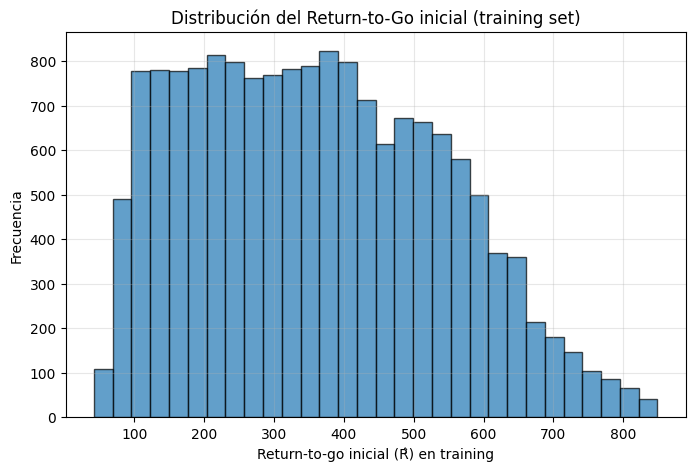

In [30]:
plt.figure(figsize=(8,5))
plt.hist(train_returns, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Return-to-go inicial (R̂) en training")
plt.ylabel("Frecuencia")
plt.title("Distribución del Return-to-Go inicial (training set)")
plt.grid(alpha=0.3)
plt.show()


Return objetivo vs HR@10

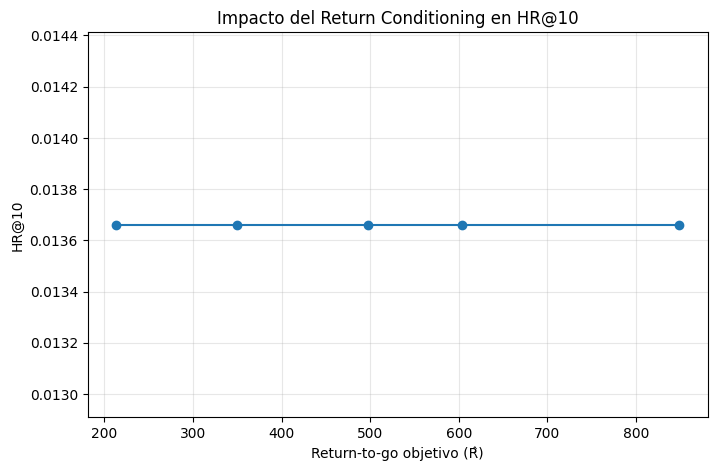

In [31]:
rtg_values = list(percentiles.values())
hr10_values = [results[name]["HR@10"] for name in percentiles.keys()]

plt.figure(figsize=(8,5))
plt.plot(rtg_values, hr10_values, marker="o")
plt.xlabel("Return-to-go objetivo (R̂)")
plt.ylabel("HR@10")
plt.title("Impacto del Return Conditioning en HR@10")
plt.grid(alpha=0.3)
plt.show()


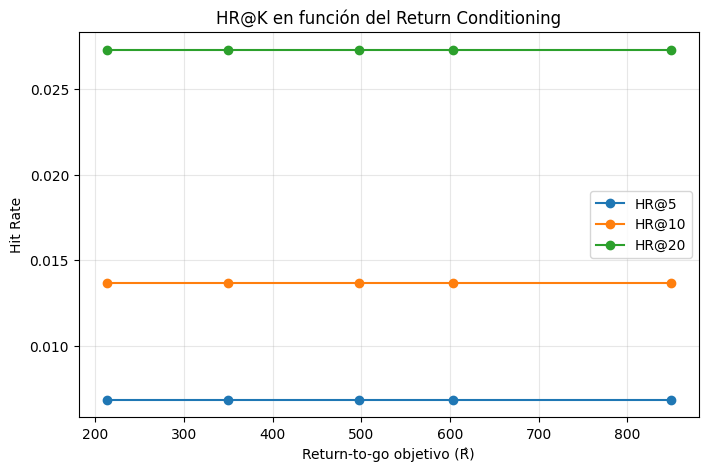

In [32]:
rtg_values = list(percentiles.values())

plt.figure(figsize=(8,5))
for k in k_list:
    vals = [results[name][f"HR@{k}"] for name in percentiles.keys()]
    plt.plot(rtg_values, vals, marker="o", label=f"HR@{k}")

plt.xlabel("Return-to-go objetivo (R̂)")
plt.ylabel("Hit Rate")
plt.title("HR@K en función del Return Conditioning")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


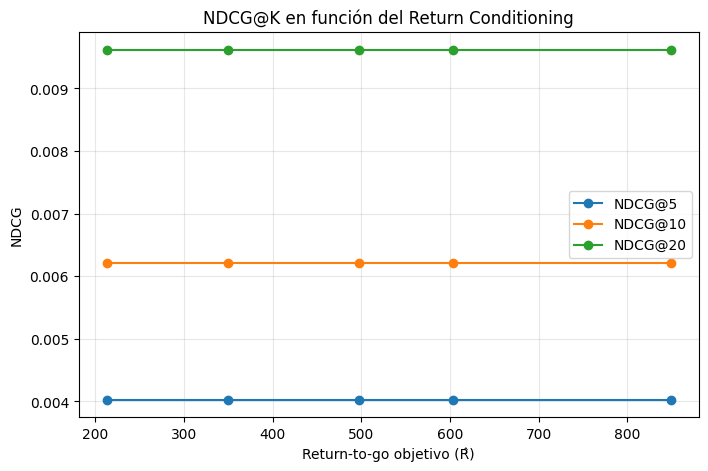

In [33]:
rtg_values = list(percentiles.values())

plt.figure(figsize=(8,5))
for k in k_list:
    vals = [results[name][f"NDCG@{k}"] for name in percentiles.keys()]
    plt.plot(rtg_values, vals, marker="o", label=f"NDCG@{k}")

plt.xlabel("Return-to-go objetivo (R̂)")
plt.ylabel("NDCG")
plt.title("NDCG@K en función del Return Conditioning")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


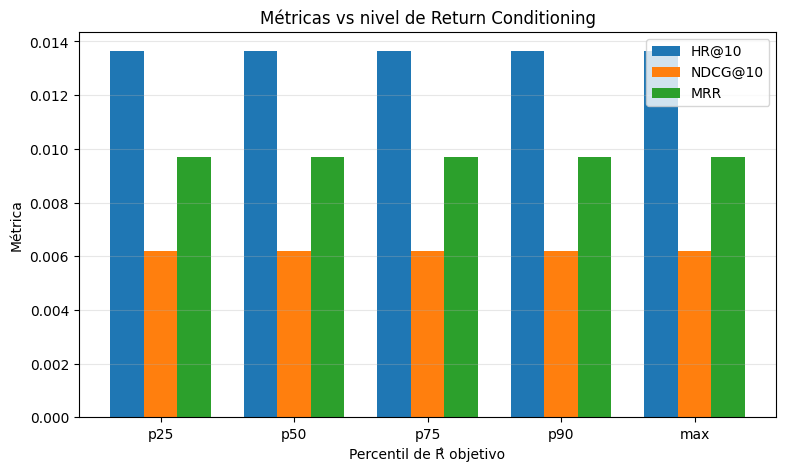

In [34]:
labels = list(percentiles.keys())
hr10 = [results[name]["HR@10"] for name in labels]
ndcg10 = [results[name]["NDCG@10"] for name in labels]
mrrs = [results[name]["MRR"] for name in labels]

x = np.arange(len(labels))
w = 0.25

plt.figure(figsize=(9,5))
plt.bar(x - w, hr10, width=w, label="HR@10")
plt.bar(x, ndcg10, width=w, label="NDCG@10")
plt.bar(x + w, mrrs, width=w, label="MRR")

plt.xticks(x, labels)
plt.xlabel("Percentil de R̂ objetivo")
plt.ylabel("Métrica")
plt.title("Métricas vs nivel de Return Conditioning")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


Cold-Start por grupo

Evaluación por grupo usando el DT

In [35]:
# === Evaluación por grupo de usuarios (cold-start) ===

results_by_group = {}

for group_id in range(8):
    # seleccionar usuarios que pertenecen al grupo actual
    users_in_group = [u for u in test_users if u["group"] == group_id]

    if len(users_in_group) == 0:
        continue

    print(f"Evaluando grupo {group_id} ({len(users_in_group)} usuarios)...")

    metrics = evaluate_model(
        model,
        users_in_group,
        DEVICE,
        target_return=percentiles["p75"],   # valor típico recomendado
        context_len=CONTEXT_LEN,
        k_list=[10]
    )

    results_by_group[group_id] = metrics

    print(f" Group {group_id} → HR@10={metrics['HR@10']:.4f}, "
          f"NDCG@10={metrics['NDCG@10']:.4f}, MRR={metrics['MRR']:.4f}")


Evaluando grupo 0 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s]


 Group 0 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 1 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


 Group 1 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 2 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


 Group 2 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 3 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


 Group 3 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 4 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


 Group 4 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 5 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


 Group 5 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 6 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:36<00:00,  1.27it/s]


 Group 6 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097
Evaluando grupo 7 (200 usuarios)...


Evaluating users: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]

 Group 7 → HR@10=0.0137, NDCG@10=0.0062, MRR=0.0097


La evaluación del Decision Transformer por grupos de usuarios (clusters 0 a 7) muestra un comportamiento completamente uniforme: todas las métricas —HR@10, NDCG@10 y MRR— presentan exactamente los mismos valores en los ocho grupos.

Este resultado indica que:

* El modelo no está diferenciando entre grupos de usuarios.
* El embedding de user_group, aunque fue incluido en la arquitectura, no parece estar generando un condicionamiento útil para personalizar recomendaciones por segmento.
* El modelo responde de la misma manera ante cualquier perfil de usuario.
Es decir, la representación del usuario tiene un impacto nulo o muy reducido en la predicción del siguiente ítem.

